In [1]:
import torch
from SPN import SPN
from matplotlib import pyplot as plt
import utils
from torchinfo import summary
import numpy as np
from DatasetGenerator import generate_dataset, torchFLPO_2_numpyFLPO 
from viz import plot_UAV_FLPO, plot_UAV_FLPO_3D
from pathlib import Path
from Anneal import anneal
import pickle
import time
import GD

### Initialize an FLPO scenario

Run the below command if you encounter errors running the plotting block.

In [2]:
# !pip install nbformat --upgrade

Running on:  cpu
num_drones = 10	 num_facilities = 4	 dim = 2	 num_distinct_ends = 2


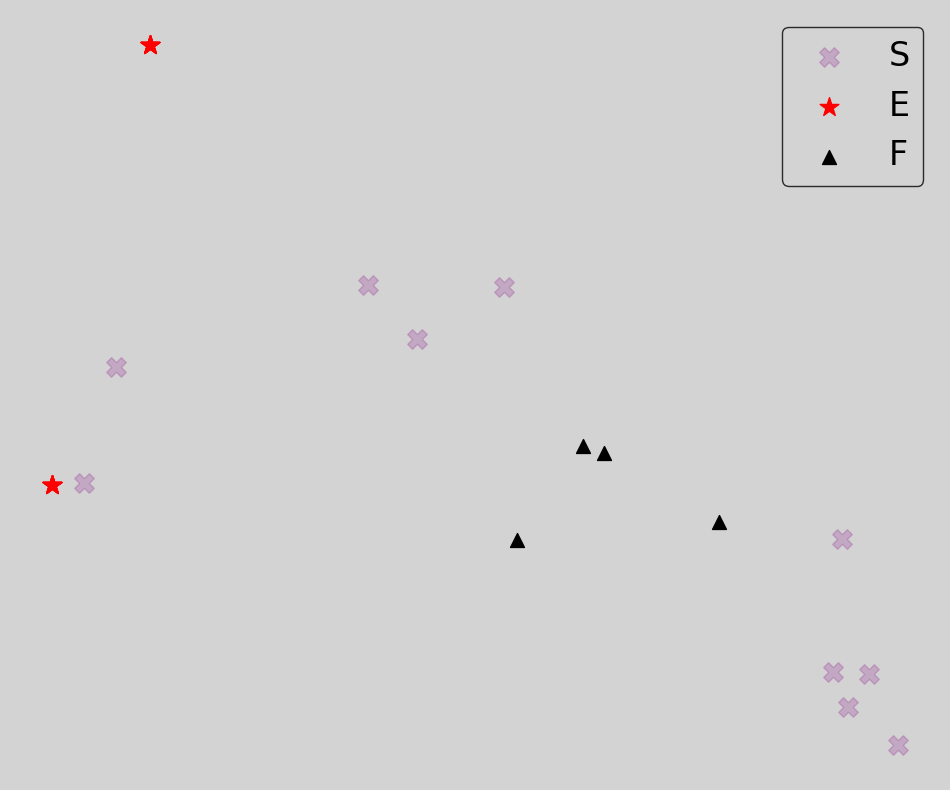

In [3]:
seed=3
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
np.random.seed(seed)
load_from_path = False
scene_path = "Benchmark/benchmark_data/N40_M4_ends2_seed3"
print("Running on: " , device)

if load_from_path:
    with open(scene_path, 'rb') as file:
        data = pickle.load(file)
    START_locs = data["START_locs"]
    F_base = data["F_base"]
    END_locs = data["END_locs"]
    num_drones = START_locs.shape[0]
    num_facilities = F_base.shape[-2]
    dim_ = F_base.shape[-1]
    num_distinct_ends = len(torch.unique(END_locs, dim=0))
    print(f"num_drones = {num_drones}\t num_facilities = {num_facilities}\t dim = {dim_}\t num_distinct_ends = {num_distinct_ends}")
    assert(F_base.requires_grad == True)
else:
    num_drones = 10
    n_drone_clusters = 3
    drone_cluster_split = np.random.uniform(0.0, 1.0, n_drone_clusters)
    drone_cluster_split = drone_cluster_split / np.sum(drone_cluster_split)
    num_facilities = 4
    num_distinct_ends = 2
    dim_ = 2
    print(f"num_drones = {num_drones}\t num_facilities = {num_facilities}\t dim = {dim_}\t num_distinct_ends = {num_distinct_ends}")
    START_locs, F_base, END_locs = generate_dataset(
        num_drones, 
        n_drone_clusters, 
        drone_cluster_split, 
        num_facilities, 
        dim_, 
        device, 
        seed,
        drone_cluster_std_range=[0.02, 0.03], 
        F_noise_std=0.05,
        num_distinct_ends=num_distinct_ends
    )
    assert(F_base.requires_grad == True)

start_locs_np = START_locs.cpu().numpy().reshape(-1,2)
end_locs_np = END_locs.cpu().numpy().reshape(-1,2)
fac_locs = F_base.detach().cpu().numpy().squeeze()

plot_UAV_FLPO(START_locs, END_locs, F_base, (12,10))
# # plot_UAV_FLPO_3D(START_locs, END_locs, F_base)

### Save a new scenario

In [8]:
benchmark_data = {
    "START_locs":START_locs, 
    "F_base":F_base, 
    "END_locs":END_locs,
}

scenario = f"N{int(num_drones)}_M{int(num_facilities)}_ends{int(num_distinct_ends)}_seed{int(seed)}"
filepath = "Benchmark/benchmark_data/" + scenario
print(filepath)

with open(filepath, 'wb') as file:
    pickle.dump(benchmark_data, file)

Benchmark/benchmark_data/N10_M4_ends2_seed3


### Load the SPN Module

In [9]:
torch.cuda.empty_cache()
model_classes = {"SPN": SPN}
weights_address = (
    Path("Saved_models") /
    "FT100_FastAnneal_2025_07_19_01_50_51.pth"
)
spn = utils.load_model(
    weights_address, model_classes, weights_only=True, device=device
)
for param in spn.parameters():
    param.requires_grad = False
print("SPN loaded on: ", spn.device)
print(summary(spn))

Model created.
SPN loaded on:  cpu
Layer (type:depth-idx)                                       Param #
SPN                                                          --
├─LinearAttnEncoder: 1-1                                     2,048
│    └─ModuleList: 2-1                                       --
│    │    └─MultiheadAttention: 3-1                          (66,048)
│    │    └─MultiheadAttention: 3-2                          (66,048)
│    │    └─MultiheadAttention: 3-3                          (66,048)
│    │    └─MultiheadAttention: 3-4                          (66,048)
│    │    └─MultiheadAttention: 3-5                          (66,048)
│    │    └─MultiheadAttention: 3-6                          (66,048)
│    └─ModuleList: 2-2                                       --
│    │    └─MultiheadAttention: 3-7                          (66,048)
│    │    └─MultiheadAttention: 3-8                          (66,048)
│    │    └─MultiheadAttention: 3-9                          (66,048)
│    │ 

### Optimization loop for a single beta


In [5]:
# optim_iters = 200
# optim_step = 0.01
# b_min = 1e-3
# beta = 1e3
# tol = 1e-3

# Y_arr_adam, FreeEnergy_adam, G_adam = GD.Adam_at_beta(
#     F_base, START_locs, END_locs, spn, optim_iters,
#     optim_step, tol=tol, allowPrint=True, return_list= True)


Using SPN and Path Sampling

In [10]:
optim_iters = 500
optim_step = 0.01
b_min = 100
beta = 1e3
tol = 0.001
n_path_samples = 4

tic = time.time()
F_base0_highbeta = F_base.clone().detach().requires_grad_(True)
F_base_sampling, FreeEnergy_sampling, G_sampling = GD.sampling_GD_at_beta_auto_diff(
    F_base0_highbeta,
    START_locs,
    END_locs,
    spn,
    n_path_samples=n_path_samples,
    beta=beta,
    stepsize=optim_step,
    iters=optim_iters,
    tol=tol,
    allowPrint=True
    )
toc = time.time()
runtime_high_beta = toc-tic


iter: 0	FreeE:0.112	Norm_G: 0.255	tolY:0.028	mean_D_min:1.660e-01
iter: 1	FreeE:0.106	Norm_G: 0.240	tolY:0.028	mean_D_min:1.624e-01
iter: 2	FreeE:0.101	Norm_G: 0.225	tolY:0.026	mean_D_min:1.568e-01
iter: 3	FreeE:0.097	Norm_G: 0.193	tolY:0.023	mean_D_min:1.532e-01
iter: 4	FreeE:0.094	Norm_G: 0.168	tolY:0.021	mean_D_min:1.448e-01
iter: 5	FreeE:0.092	Norm_G: 0.151	tolY:0.019	mean_D_min:1.414e-01
iter: 6	FreeE:0.090	Norm_G: 0.149	tolY:0.018	mean_D_min:1.382e-01
iter: 7	FreeE:0.088	Norm_G: 0.161	tolY:0.017	mean_D_min:1.372e-01
iter: 8	FreeE:0.085	Norm_G: 0.149	tolY:0.017	mean_D_min:1.309e-01
iter: 9	FreeE:0.083	Norm_G: 0.160	tolY:0.018	mean_D_min:1.229e-01
iter: 10	FreeE:0.081	Norm_G: 0.156	tolY:0.018	mean_D_min:1.189e-01
iter: 11	FreeE:0.078	Norm_G: 0.139	tolY:0.018	mean_D_min:1.166e-01
iter: 12	FreeE:0.076	Norm_G: 0.123	tolY:0.018	mean_D_min:1.161e-01
iter: 13	FreeE:0.074	Norm_G: 0.107	tolY:0.018	mean_D_min:1.164e-01
iter: 14	FreeE:0.073	Norm_G: 0.092	tolY:0.018	mean_D_min:1.132e-01
iter:

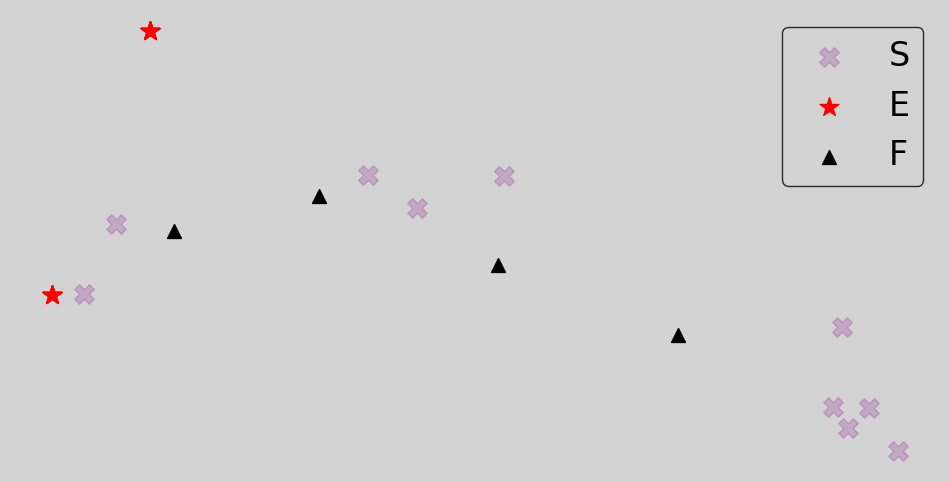

In [11]:
plot_UAV_FLPO(START_locs, END_locs, F_base_sampling, (12,6))


### Save the high beta results (plotting done in plot_res.ipynb)

In [31]:
scenario = f"N{int(num_drones)}_M{int(num_facilities)}_ends{int(num_distinct_ends)}_seed{int(seed)}"
file_path0 = "AAAI26_res/high_beta_res/" + scenario
print(file_path0)
# file_path0 = "AAAI26_res/low_beta_res/" + scenario

high_beta_res_data = {
    "START_locs":START_locs,
    "END_locs":END_locs,
    "F_base":F_base_sampling,
    "n_ends":num_distinct_ends,
    "F_base0":F_base0_highbeta,
    "optim_method":"sampling_GD_at_beta_auto_diff",
    "optim_iters":optim_iters,
    "optim_step":optim_step,
    "beta":beta,
    "optim_tol":tol,
    "n_path_samples":n_path_samples,
    "Free_energy_final":FreeEnergy_sampling,
    "Gradient_final":G_sampling,
    "runtime":runtime_high_beta
}

with open(file_path0, 'wb') as file:
    pickle.dump(high_beta_res_data, file)

AAAI26_res/high_beta_res/N100_M5_ends4_seed3


### Annealing loop implementation
Warning: Use $\beta >= 1e-3$, as the free energy approximation is poor for $\beta < 5e-4$ with torch.float32 datatype.

beta: 1.0000e-03	FreeE: -2564.7856	Grad: 6.9330e-02
beta: 1.0000e-02	FreeE: -256.3204	Grad: 6.9478e-02
beta: 1.0000e-01	FreeE: -25.4845	Grad: 3.1825e-02
beta: 1.0000e+00	FreeE: -2.4067	Grad: 7.2849e-02
beta: 1.0000e+01	FreeE: -0.1157	Grad: 5.9810e-02
beta: 1.0000e+02	FreeE: 0.0524	Grad: 9.2520e-02
beta: 1.0000e+03	FreeE: 0.0617	Grad: 3.2194e-02


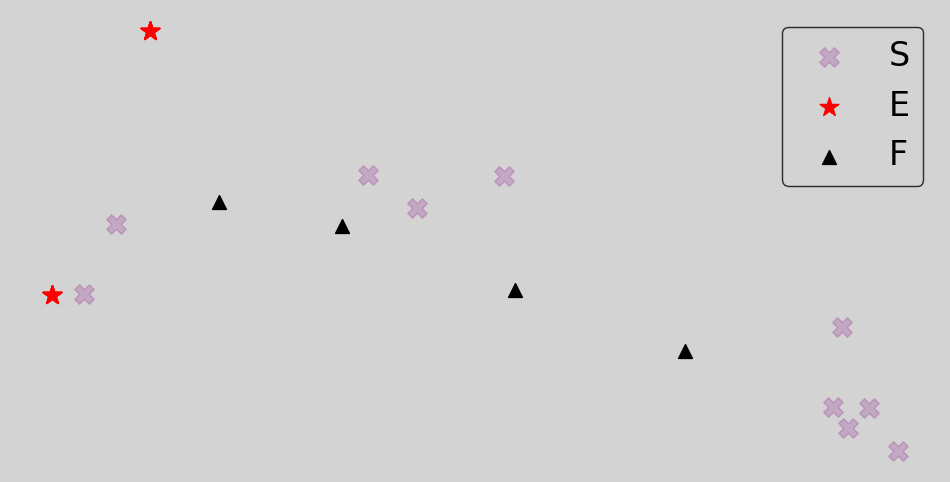

In [12]:
beta_min = 1e-3 
beta_max = 1e3
beta_grow = 10
optim_iters = 100
optim_step = 0.01 # 0.1 for gd0, sampling_gd, use < 0.01 for the other two optimizers 
optim_name = "sampling_auto_diff"
tol = 0.001
n_path_samples = 8

tic = time.time()
F_base0_anneal = F_base.clone().detach().requires_grad_(True)
Y_arr, b_arr, F_arr = anneal( 
        F_base0_anneal, 
        START_locs, 
        END_locs, 
        spn,  
        optim_iters, 
        optim_step, 
        beta_min, 
        beta_max, 
        beta_grow, 
        tol=tol, 
        optimizer_name=optim_name, 
        n_path_samples=n_path_samples, 
        allowPrint=True 
    ) 
toc = time.time()
runtime_anneal = toc-tic
plot_UAV_FLPO(START_locs, END_locs, Y_arr[-1], (12,6))


### Save the annealing results (plotting done in plot_res.ipynb)

In [33]:
file_path1 = "AAAI26_res/annealing_res/" + scenario
print(f'filepath: {file_path1}')

annealing_res_data = {
    "START_locs":START_locs,
    "END_locs":END_locs,
    "Y_arr":Y_arr,
    "b_arr":b_arr,
    "F_arr":F_arr,
    "F_bas0":F_base0_anneal,
    "optim_method":optim_name,
    "optim_iters":optim_iters,
    "optim_step":optim_step,
    "optim_tol":tol,
    "n_path_samples":n_path_samples,
    "runtime":runtime_anneal
}

with open(file_path1, 'wb') as file:
    pickle.dump(annealing_res_data, file)

filepath: AAAI26_res/annealing_res/N100_M5_ends4_seed3


### Animation results moved to plot_res.ipynb